**Guilherme Sales Santa Cruz**

**05/08/2022**
________________________________

**The impacts of the threshold choice on the shape parameter for extreme value risk estimates of financial time series**

Studies suggest that there is no absolute way to choose the threshold u for computing Value at Risk (VaR) using the Generalized Pareto Distribution approach. Some authors propose thresholds at a fixed percentage of points from the original sample between 5% and 10%. Others propose to verify the linearity in the life residual plot. This work proposes deeper look in the confidence interval of the shape parameter (xi) estimator as a new criteria on the heuristic task of setting the threshold.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto, probplot
import datetime as dt

In [2]:
threshold = -0.03
period = 1
plt.style.use('seaborn-poster')

# Extreme Value Theory for Risk Estimation Background

One of the new traditional ways of measuring VaR is by modeling the tail of the returns distribution using EVT. For that, we look at the returns $X_1, X_2, ... , X_N$ and assume that they are i.i.d. coming from the same unknown distribution $F$.

From those returns, we are interested in modeling the values above a certain threshold $u$, such that:

$$F_u(x) = P(X - u \le x | X \gt u) = \frac{F(u+x) - F(u)}{1 - F(u)} $$

Using the Pickands-Balkema-de Haan theorem we can approximate $F_u$ by the Generalized Pareto distribution $G_{\xi, \sigma}$. 

$$
 G_{\xi, \sigma}(x) =
  \begin{cases}
    1 - (1 + \xi x/\sigma)^{-1/\xi}      & \quad \text{if } \xi \neq 0 \\
    1 - e^{-x/\sigma}  & \quad \text{if } \xi = 0
  \end{cases}
$$

Where $\xi$ is the shape parameter and $\sigma$ is the scale parameter (not the standard deviation). Therefore, we have:

$$ G_{\xi, \sigma}(x) = \frac{F(u+x) - F(u)}{1 - F(u)}$$


To obtain $F$ we need first to find $F(u)$.

$$F(u) = P(X \ge u) = 1 - \frac{N_u}{N}$$

Where $N$ is the total number of observations in the original sample and $N_u$ is the number of observations above the threshold $u$.

Combining the equations, we have:

$$F(x) = 1 - \frac{N_u}{N} \Big( 1 + \xi\frac{x-u}{\sigma} \Big)^{-1/\xi}$$

Having this approximation of $F$ we can define $VaR_\alpha$ as:

$$ 
F(VaR_\alpha) = \alpha \\
VaR_\alpha = F^{-1}(\alpha)
$$



Solving for $F^{-1}$ we have:

$$VaR_\alpha = u + \frac{\sigma}{\xi} \Bigg(\Big(\frac{N}{N_u}(1-\alpha)\Big)^{-\xi} - 1 \Bigg) $$

# Demonstration

## Get the Universe data (SP500)

In [3]:
# Get the yf ticker
spx_ticker = '^GSPC'
tickers = yf.Tickers(spx_ticker)

# Get maximum history (< 100y)
df_spx = tickers.tickers[spx_ticker].history(period='100y')[['Close']]

# Compute the log close and the log returns
df_spx['log_close'] = df_spx['Close'].map(np.log)
df_spx['log_close_diff_period'] = df_spx['log_close'].diff(periods=period)

# display the data
df_spx.head()

,Close,log_close,log_close_diff_period
Date,,,
1927-12-30,17.660000,2.871302,NaN
1928-01-03,17.760000,2.876949,0.005647
1928-01-04,17.719999,2.874694,-0.002255
1928-01-05,17.549999,2.865054,-0.009640
1928-01-06,17.660000,2.871302,0.006248


The graph below shows the points in time selected with the threshold. The extreme points are aligned with times of market crisis.

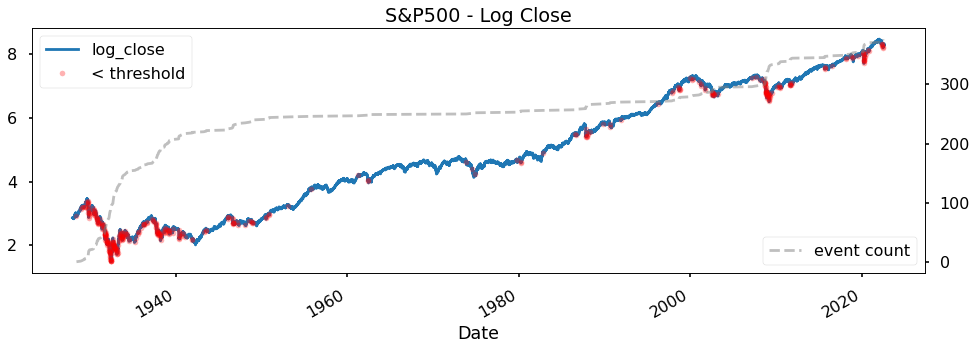

In [4]:
ax = df_spx['log_close'].plot()
ax.set_title('S&P500 - Log Close');

df_spx[
    df_spx['log_close_diff_period'] < threshold
      ]['log_close'].plot(style='.', color='red', label='< threshold', ax=ax, alpha=0.3)

ax2 = ax.twinx()
df_spx[1] = 1
df_spx[
    df_spx['log_close_diff_period'] < threshold
      ][1].cumsum().plot(style='--', color='grey', label='event count', ax=ax2, alpha=0.5)

ax2.legend(loc = 'lower right')
ax.legend(loc = 'upper left');
plt.gcf().set_size_inches(16,5);

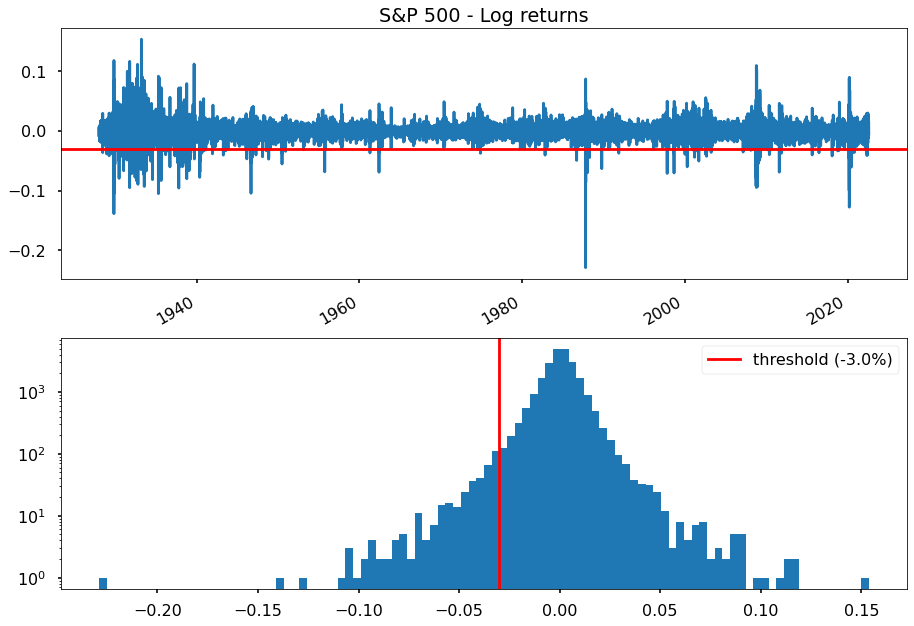

In [5]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2)

df_spx['log_close_diff_period'].plot(ax=ax)
ax.axhline(threshold, color='red', label='threshold')
ax.set_title('S&P 500 - Log returns');
ax.set_xlabel('')

ax = ax1
df_spx['log_close_diff_period'].hist(bins=100, ax=ax)

ax.set_yscale('log')

ax.grid(False)
ax.axvline(threshold, color='red', label=f'threshold ({100*threshold}%)');
ax.legend();


fig.tight_layout()


### Get extreme points

In [6]:
# Get the points above the threshold POT approach
_se = df_spx[
    df_spx['log_close_diff_period'] < threshold
      ]['log_close_diff_period']

# Make the extreme points positive
df_pot = (-_se + threshold).to_frame().reset_index()
df_pot['ccdf'] = df_pot['log_close_diff_period'].rank(pct=True, ascending=False)

## Fit GPD

In [7]:
# Fit genpareto dist
param_fit = genpareto.fit(df_pot['log_close_diff_period'], floc=0)
c, loc, scale = param_fit

print(f'GPD parameters fit:\nc     = {c} \nloc   = {loc} \nscale = {scale}')

GPD parameters fit:
c     = 0.265712393518334 
loc   = 0 
scale = 0.011292395786859475


## Xi likelihood

Compute the xi likelihood using a grid sampling mehtod. Deterministic sampling methods are good for low dimensional cases.

In [8]:
%%time
def compute_grid_likelihood(df_pot, start=0.001, end=3, sample=1000):
    '''
    Computes the grid likelihood distribution of the shape parameter c of genpareto
    
    Args:
        - df: [ log_close_diff_period > threshold ]
    '''
    
    c_space = np.linspace(start,end,sample)

    # take the empirical distribution
    c_dist = [[_c, genpareto(c=_c, loc=loc, scale=scale).logpdf(df_pot['log_close_diff_period']).sum()] for _c in c_space]

    df_c = pd.DataFrame(c_dist, columns=['xi', 'log_likelihood'])
    df_c = df_c.replace([-np.inf, np.inf], np.nan).dropna()

    # Add a constant before applying the exp
    df_c['log_likelihood_scaled'] = df_c['log_likelihood'] - df_c['log_likelihood'].max()
    df_c['likelihood_scaled'] = df_c['log_likelihood_scaled'].map(np.exp)
    df_c['likelihood_scaled'] = df_c['likelihood_scaled']/df_c['likelihood_scaled'].sum()
    df_c = df_c.set_index('xi')
    return df_c

df_c = compute_grid_likelihood(df_pot=df_pot.copy())
df_c.head()

CPU times: user 650 ms, sys: 8.2 ms, total: 658 ms
Wall time: 701 ms


,log_likelihood,log_likelihood_scaled,likelihood_scaled
xi,,,
0.001000,1180.436219,-29.482813,3.546555e-15
0.004002,1181.599180,-28.319853,1.134682e-14
0.007004,1182.709545,-27.209488,3.444288e-14
0.010006,1183.771135,-26.147898,9.957312e-14
0.013008,1184.787319,-25.131714,2.750840e-13


In [9]:
def confidence_interval(df, level=0.95, bool_unsafe=True):
    '''
    Computes the confidence interval starting from the maximum value and
    iteratively including the highest neighboor.
    
    Args:
        - df: [ (xi) | likelihood_scaled ]
    
    '''
    
    if not bool_unsafe:
        assert np.abs(df['likelihood_scaled'].sum() - 1) < 1e-4
    
    idx = df.index.name
    df = df.sort_index()['likelihood_scaled'].cumsum().rename('P').reset_index()
    ml_idx = df['P'].diff().argmax()
    se_slope = df['P'].diff()/df[idx].diff()
    a=b=0

    try:
        while df.iloc[ml_idx+b+1]['P'] - df.iloc[ml_idx-a]['P'] < level:
            if ml_idx-(a+1) < 1:
                b=b+1
                continue
            if ml_idx+b+1 >= len(df):
                a=a+1
                continue
            
            slope_a = se_slope.iloc[ml_idx-a]
            slope_b = se_slope.iloc[ml_idx+b+1]
            
            if slope_b < slope_a:
                a=a+1
            else:
                b=b+1
    except:
        return np.nan, np.nan
    
    list_ret = df[idx].iloc[[ml_idx-a,ml_idx+b+1]].to_list()

    # TODO: debug the case when max < min
    if list_ret[0] > list_ret[1]:
        return np.nan, np.nan
    
    return list_ret[0], list_ret[1]

In [10]:
xi_low, xi_high = confidence_interval(df=df_c.copy())

print(f'xi 95% confidence interval :\n {[xi_low, xi_high]}')

xi 95% confidence interval :
 [0.17211411411411412, 0.38225425425425424]


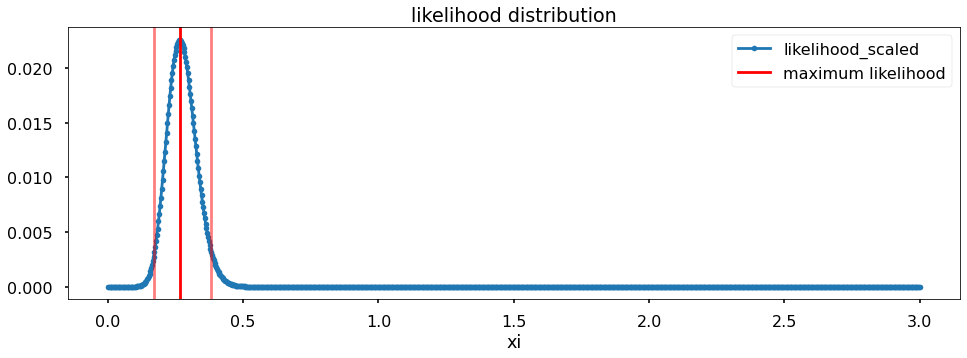

In [11]:
ax = df_c[['likelihood_scaled']].plot(style='.-')
ax.axvline(c, color='red', label='maximum likelihood')
ax.axvline(xi_low, color='red', alpha=0.5)
ax.axvline(xi_high, color='red', alpha=0.5)

ax.legend();
ax.set_title('likelihood distribution');
# ax.set_xscale('log');
# ax.set_yscale('log');

plt.gcf().set_size_inches(16,5);

### Estimate VaR and ES

This work focuses mostly on VaR. ES, stands for Expected Shortfall, and is also known as conditional VaR. It measures the expected value of the distribution beyond the threshold.

In [12]:
def VaR_ES(u, c, scale, N, Nu, alpha = 0.95):

    _u = -u
    
    VaR = _u + scale/c*((np.power((N/Nu*(1-alpha)), -c))-1)
    ES = (VaR + scale - c*(_u))/(1-c)
    
    return VaR, ES

alpha = 0.99
N  = len(df_spx[df_spx['log_close_diff_period'] < 0])
Nu = len(df_spx[df_spx['log_close_diff_period'] < threshold])
VaR, ES = VaR_ES(u=threshold, c=c, scale=scale, N=N, Nu=Nu, alpha=alpha)

print(f'VaR  : {VaR}\nES   : {ES}\nN    : {N}\nNu   : {Nu}\nalpha: {alpha}')

VaR  : 0.046408624709889504
ES   : 0.06772502797572497
N    : 11004
Nu   : 376
alpha: 0.99


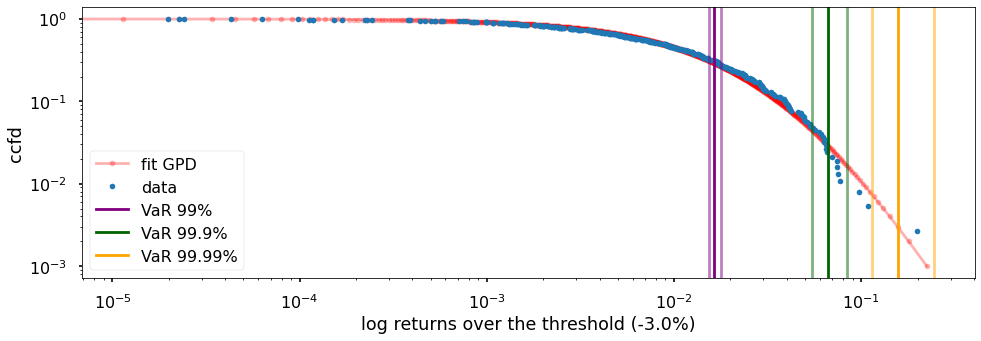

In [13]:
c, loc, scale = param_fit
ax = plt.gca()

# Plot genpareto fit
x = np.linspace(0,1,num=1000)
y = genpareto.ppf(q=x, c=c, loc=loc, scale=scale)
ax.plot(y,1-x, 'r.-', label='fit GPD', alpha=0.3)

# plot data
df_pot.set_index('log_close_diff_period')['ccdf'].plot(style='.', ax=ax, label='data')

# plot risk estimates
ax.axvline(VaR-(-threshold), label='VaR 99%', color='purple')
VaR_lo, _ = VaR_ES(u=threshold, c=xi_low, scale=scale, N=N, Nu=Nu, alpha=0.99)
VaR_hi, _ = VaR_ES(u=threshold, c=xi_high, scale=scale, N=N, Nu=Nu, alpha=0.99)
ax.axvline(VaR_lo-(-threshold), alpha=0.5, color='purple')
ax.axvline(VaR_hi-(-threshold), alpha=0.5, color='purple')


VaR2, _ = VaR_ES(u=threshold, c=c, scale=scale, N=N, Nu=Nu, alpha=0.999)
ax.axvline(VaR2-(-threshold), label='VaR 99.9%', color='darkgreen')
VaR_lo, _ = VaR_ES(u=threshold, c=xi_low, scale=scale, N=N, Nu=Nu, alpha=0.999)
VaR_hi, _ = VaR_ES(u=threshold, c=xi_high, scale=scale, N=N, Nu=Nu, alpha=0.999)
ax.axvline(VaR_lo-(-threshold), alpha=0.5, color='darkgreen')
ax.axvline(VaR_hi-(-threshold), alpha=0.5, color='darkgreen')


VaR3, _ = VaR_ES(u=threshold, c=c, scale=scale, N=N, Nu=Nu, alpha=0.9999)
ax.axvline(VaR3-(-threshold), label='VaR 99.99%', color='orange')
VaR_lo, _ = VaR_ES(u=threshold, c=xi_low, scale=scale, N=N, Nu=Nu, alpha=0.9999)
VaR_hi, _ = VaR_ES(u=threshold, c=xi_high, scale=scale, N=N, Nu=Nu, alpha=0.9999)
ax.axvline(VaR_lo-(-threshold), alpha=0.5, color='orange')
ax.axvline(VaR_hi-(-threshold), alpha=0.5, color='orange')

# configure plot
ax.legend()
ax.set_xlabel(f'log returns over the threshold ({threshold*100}%)')
ax.set_ylabel('ccfd')
ax.set_xscale('log')
ax.set_yscale('log');


plt.gcf().set_size_inches(16,5);

# Run the experiment

Run the same as above for many companies and many different thresholds and save results into a data frame.


Note: for this experiment the loss expected by VaR or ES is displayed as a positive number.


In [14]:
# Create custom function to compute the beta of an asset
#
#     Note: beta is a measure of how much can the market
#           explain the returns of one of its assets
#

def compute_beta(df_tic, df_spx=df_spx):
    _df = df_spx[['log_close_diff_period']].join(df_tic[['log_close_diff_period']], rsuffix='_')
    beta = _df.corr().min().min()*_df['log_close_diff_period_'].std()/_df['log_close_diff_period'].std()
    return beta

In [15]:
# Testing tickers
list_tickers = ['^GSPC','AAPL','IBM','GM',
                'TSLA','JPM','META','JNJ',
                'XOM','PG','V','PFE',
                'AMZN','KO','MCD','DIS']#'BRK']

# BRK data was not clean when this experiment was run for the first time and it was excluded from the sample.

In [16]:
## All S&P500 tickers
## Source: https://pythonprogramming.net/sp500-company-list-python-programming-for-finance/

# list_tickers = ['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DISH', 'DIS', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DTE', 'DUK', 'DRE', 'DD', 'DXC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'LLY', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'RE', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FAST', 'FRT', 'FDX', 'FITB', 'FRC', 'FE', 'FIS', 'FISV', 'FLT', 'FMC', 'F', 'FTNT', 'FTV', 'FBHS', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GNRC', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GL', 'GPN', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'ILMN', 'INCY', 'IR', 'INTC', 'ICE', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IQV', 'IRM', 'JBHT', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LNC', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LUMN', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NWL', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NLOK', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OGN', 'OTIS', 'PCAR', 'PKG', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PENN', 'PNR', 'PEP', 'PKI', 'PFE', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SEE', 'SRE', 'NOW', 'SHW', 'SBNY', 'SPG', 'SWKS', 'SJM', 'SNA', 'SEDG', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STE', 'SYK', 'SIVB', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TWTR', 'TYL', 'TSN', 'USB', 'UDR', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VFC', 'VTRS', 'VICI', 'V', 'VNO', 'VMC', 'WAB', 'WBA', 'WMT', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WRK', 'WY', 'WHR', 'WMB', 'WTW', 'GWW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']
len(list_tickers)

16

## Data Description 

In [17]:
tickers = yf.Tickers(list_tickers)
df_tickers_all = tickers.history(period='100y')[['Close']]

[*********************100%***********************]  16 of 16 completed


In [18]:
df_tickers_all = df_tickers_all['Close'].applymap(np.log).diff().describe().T

# print(df_tickers_all.to_latex())

df_tickers_all

,count,mean,std,min,25%,50%,75%,max
AAPL,10500.0,0.000705,0.028757,-0.731248,-0.013133,0.000000,0.014629,0.286892
AMZN,6348.0,0.001145,0.035813,-0.284568,-0.013248,0.000486,0.014690,0.296181
DIS,15253.0,0.000492,0.019895,-0.343821,-0.009662,0.000000,0.010309,0.174755
GM,2947.0,0.000104,0.021625,-0.190227,-0.010313,0.000278,0.010691,0.181848
IBM,15253.0,0.000286,0.015942,-0.268122,-0.007752,0.000000,0.008164,0.123664
JNJ,15253.0,0.000514,0.014519,-0.202781,-0.006927,0.000000,0.007630,0.147516
JPM,10688.0,0.000433,0.022521,-0.324613,-0.009784,0.000000,0.010425,0.223917
KO,15253.0,0.000468,0.014612,-0.283576,-0.006829,0.000000,0.007558,0.179586
MCD,14118.0,0.000542,0.019463,-0.707640,-0.008231,0.000000,0.009174,0.166577
META,2570.0,0.000572,0.024565,-0.306391,-0.009859,0.000967,0.012492,0.259371


In [19]:
%%time
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . #
# .                                                       . #
# .  This cell simulates the first part of this notebook  . #
# .  for different tickers (companies, indexes or other   . #
# .  assets) at different threshold (u) levels.           . #
# .                                                       . #
# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

#################### get yf ticker object ####################
tickers = yf.Tickers(list_tickers)

list_experiment = list()

############ run experiment for different assets #############
for ticker in list_tickers:

    df_tic = tickers.tickers[ticker].history(period='100y')[['Close']]

    df_tic['log_close'] = df_tic['Close'].map(np.log)
    df_tic['log_close_diff_period'] = df_tic['log_close'].diff(periods=period)

    beta = compute_beta(df_tic)
    total_negative_ret = len(df_tic[df_tic['log_close_diff_period'] < 0])
    
    ########## run experiment for different thresholds ###########
    list_threshold = -np.linspace(0,1, 1000)

    for u in list_threshold:

        # Get the points above the threshold POT approach
        _se = df_tic[
            df_tic['log_close_diff_period'] < u
              ]['log_close_diff_period']

        # Only take samples with less than 50% of the original number of points
        if len(_se)/total_negative_ret > 0.5:
            continue
        
        # Only take samples with 10 points or more
        if len(_se) < 10:
            break

        # Prepare the sample by subtracting the threshold (u)
        df_pot = (-_se + u).to_frame().reset_index()
        df_pot['ccdf'] = df_pot['log_close_diff_period'].rank(pct=True, ascending=False)
        count = len(df_pot)

        # fit the GPD parameters
        param_fit = genpareto.fit(df_pot['log_close_diff_period'], floc=0)
        c, loc, scale = param_fit

        # compute the likelihood distribution
        df_c = compute_grid_likelihood(df_pot=df_pot.copy())
        
        # get xi confidence interval
        xi_low, xi_high = confidence_interval(df=df_c.copy())
        
        # compute VaR and ES
        VaR, ES = VaR_ES(u=u, c=c, scale=scale,
                         N=total_negative_ret,
                         Nu=count, alpha=0.95)

        _df = pd.DataFrame(
            [
                list(param_fit) +
                [u, beta, ticker, count, 
                 total_negative_ret, VaR,
                 ES, xi_low, xi_high]
            ],
            columns=['xi', 'loc', 'scale',
                     'u', 'beta', 'ticker',
                     'N_u', 'N', 'VaR', 'ES',
                     'xi_low', 'xi_high']
        )

        list_experiment.append(_df)

CPU times: user 17min 26s, sys: 7.17 s, total: 17min 33s
Wall time: 18min 21s


In [20]:
df_res = pd.concat(list_experiment)
df_res['pct_n'] = df_res['N_u'] / df_res['N']

df_res[['VaR_low', 'ES_low']] = df_res.apply(
    lambda se: pd.Series(VaR_ES(u=se['u'], c=se['xi_low'], scale=se['scale'],
                                N=se['N'], Nu=se['N_u'], alpha=0.95)), axis=1)

df_res[['VaR_high', 'ES_high']] = df_res.apply(
    lambda se: pd.Series(VaR_ES(u=se['u'], c=se['xi_high'], scale=se['scale'],
                                N=se['N'], Nu=se['N_u'], alpha=0.95)), axis=1)

df_res = df_res.set_index(['ticker','u']).sort_index()
df_res.sample(5).sort_index()

xi  loc     scale      beta   N_u     N       VaR  \
ticker u                                                                    
AAPL   -0.040040  0.237351    0  0.016514  1.156512   584  4915  0.055909   
       -0.038038  0.225652    0  0.016502  1.156512   651  4915  0.056019   
JNJ    -0.067067  0.528232    0  0.011611  0.659581    20  7131  0.049885   
PG     -0.017017  0.211522    0  0.007867  0.614589  1006  7086  0.026204   
XOM    -0.012012  0.162763    0  0.007978  0.758982  2160  6961  0.028971   

                        ES    xi_low   xi_high     pct_n   VaR_low    ES_low  \
ticker u                                                                       
AAPL   -0.040040  0.082501  0.169112  0.319212  0.118820  0.055434  0.078442   
       -0.038038  0.082570  0.160106  0.301200  0.132452  0.055436  0.078401   
JNJ    -0.067067  0.055259  0.142094  1.477985  0.002805  0.039618  0.048606   
PG     -0.017017  0.038647  0.160106  0.271180  0.141970  0.025953  0.037024   
XOM    -0.012012  0.041798  0.127084  0.199132  0.310300  0.028404  0.039931   

                  VaR_high   ES_high  
ticker u                              
AAPL   -0.040040  0.056504  0.088482  
       -0.038038  0.056722  0.088391  
JNJ    -0.067067  0.059322  0.058978  
PG     -0.017017  0.026507  0.040833  
XOM    -0.012012  0.029576  0.043905

In [21]:
# filter results
df_res = df_res[
    (df_res['xi']<1) &
    (df_res['xi']>0)
]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:7842: RuntimeWarning: invalid value encountered in log10
  return lib.map_infer(x.astype(object)._values, func, ignore_na=ignore_na)


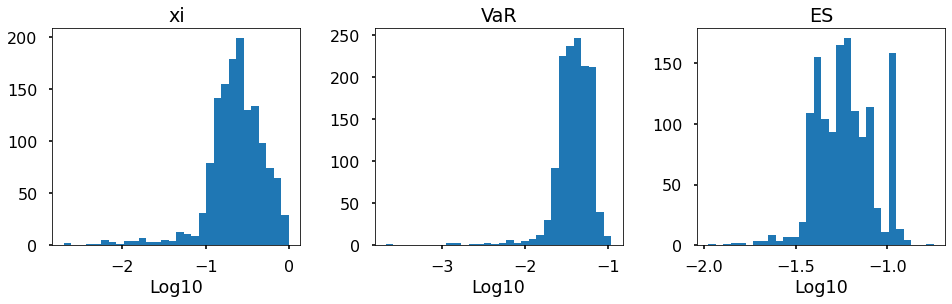

In [22]:
axis = df_res[
    (df_res['xi']<1) &
    (df_res['xi']>0)
][['xi', 'VaR', 'ES']].applymap(np.log10).hist(
    bins=30, grid=False, layout=(1,3), figsize=(16,4)
);

for ax in axis.flatten():
    ax.set_xlabel('Log10')

## Threshold plots with confidence interval

In [23]:
def plot_confidence_interval(method='xi', log_y_bool=True, list_tickers=list_tickers, df_res=df_res):
    fig, axis = plt.subplots(nrows=5, ncols=3)
    list_ax = axis.flatten()[:len(list_tickers)]
    
    for ticker,ax in zip(list_tickers, list_ax):
        df_res.loc[ticker][[method]].plot(ax=ax, color='darkcyan')
        df_res.loc[ticker][f'{method}_low'].plot(ax=ax, color='darkcyan', alpha=0.3, label=None)
        df_res.loc[ticker][f'{method}_high'].plot(ax=ax, color='darkcyan', alpha=0.3, label=None)

        if method == 'xi':
            ax.axhline(1/2, color='grey')
            ax.axhline(1/3, color='grey')
            ax.axhline(1/4, color='grey')

        ax.invert_xaxis()
        ax.legend(loc='upper left')
        if log_y_bool:
            ax.set_yscale('log')

        ax2 = ax.twinx()
        df_res.loc[ticker][['pct_n']].rename(columns={'pct_n':'Nu/N'}).plot(ax=ax2, color='grey', alpha=0.5);
        ax2.set_yscale('log')
        ax2.legend(loc='upper right')
        
        if method == 'VaR':
            _se_u = df_res[
                (df_res['pct_n'] > 0.05) &
                (df_res['pct_n'] <= 0.1)
            ].loc[ticker].reset_index()['u']
            ax2.axvline(_se_u.max(), color='red')
            ax2.axvline(_se_u.min(), color='green')
            

        ax.set_title(ticker);
    fig.set_size_inches(20, 30)
    fig.tight_layout()
    

In [24]:
def plot_confidence_interval(method='xi',
                              log_y_bool=True,
                              list_tickers=list_tickers,
                              df_res=df_res,
                              ncols=3):
    nrows = int(np.ceil(len(list_tickers)/ncols))
    fig, axis = plt.subplots(nrows=nrows, ncols=ncols)
    list_ax = axis.flatten()[:len(list_tickers)]
    
    for ticker,ax in zip(list_tickers, list_ax):
        df_res.loc[ticker][[method]].plot(ax=ax, color='darkcyan')
        df_res.loc[ticker][f'{method}_low'].plot(ax=ax, color='darkcyan', alpha=0.3, label=None)
        df_res.loc[ticker][f'{method}_high'].plot(ax=ax, color='darkcyan', alpha=0.3, label=None)

        if method == 'xi':
            ax.axhline(1, color='grey')
            ax.axhline(1/2, color='grey')
            ax.axhline(1/3, color='grey')
            ax.axhline(1/4, color='grey')

        ax.invert_xaxis()
        ax.legend(loc='upper left')
        if log_y_bool:
            ax.set_yscale('log')

        ax2 = ax.twinx()
        df_res.loc[ticker][['pct_n']].rename(columns={'pct_n':'Nu/N'}).plot(ax=ax2, color='grey', alpha=0.5);
        ax2.set_yscale('log')
        ax2.legend(loc='upper right')
        
        if method == 'VaR':
            _se_u = df_res[
                (df_res['pct_n'] > 0.05) &
                (df_res['pct_n'] <= 0.1)
            ].loc[ticker].reset_index()['u']
            ax2.axvline(_se_u.max(), color='red')
            ax2.axvline(_se_u.min(), color='green')
            

        ax.set_title(ticker);
    fig.set_size_inches(6*ncols, 5*nrows)
    fig.tight_layout()
    

### $\xi$

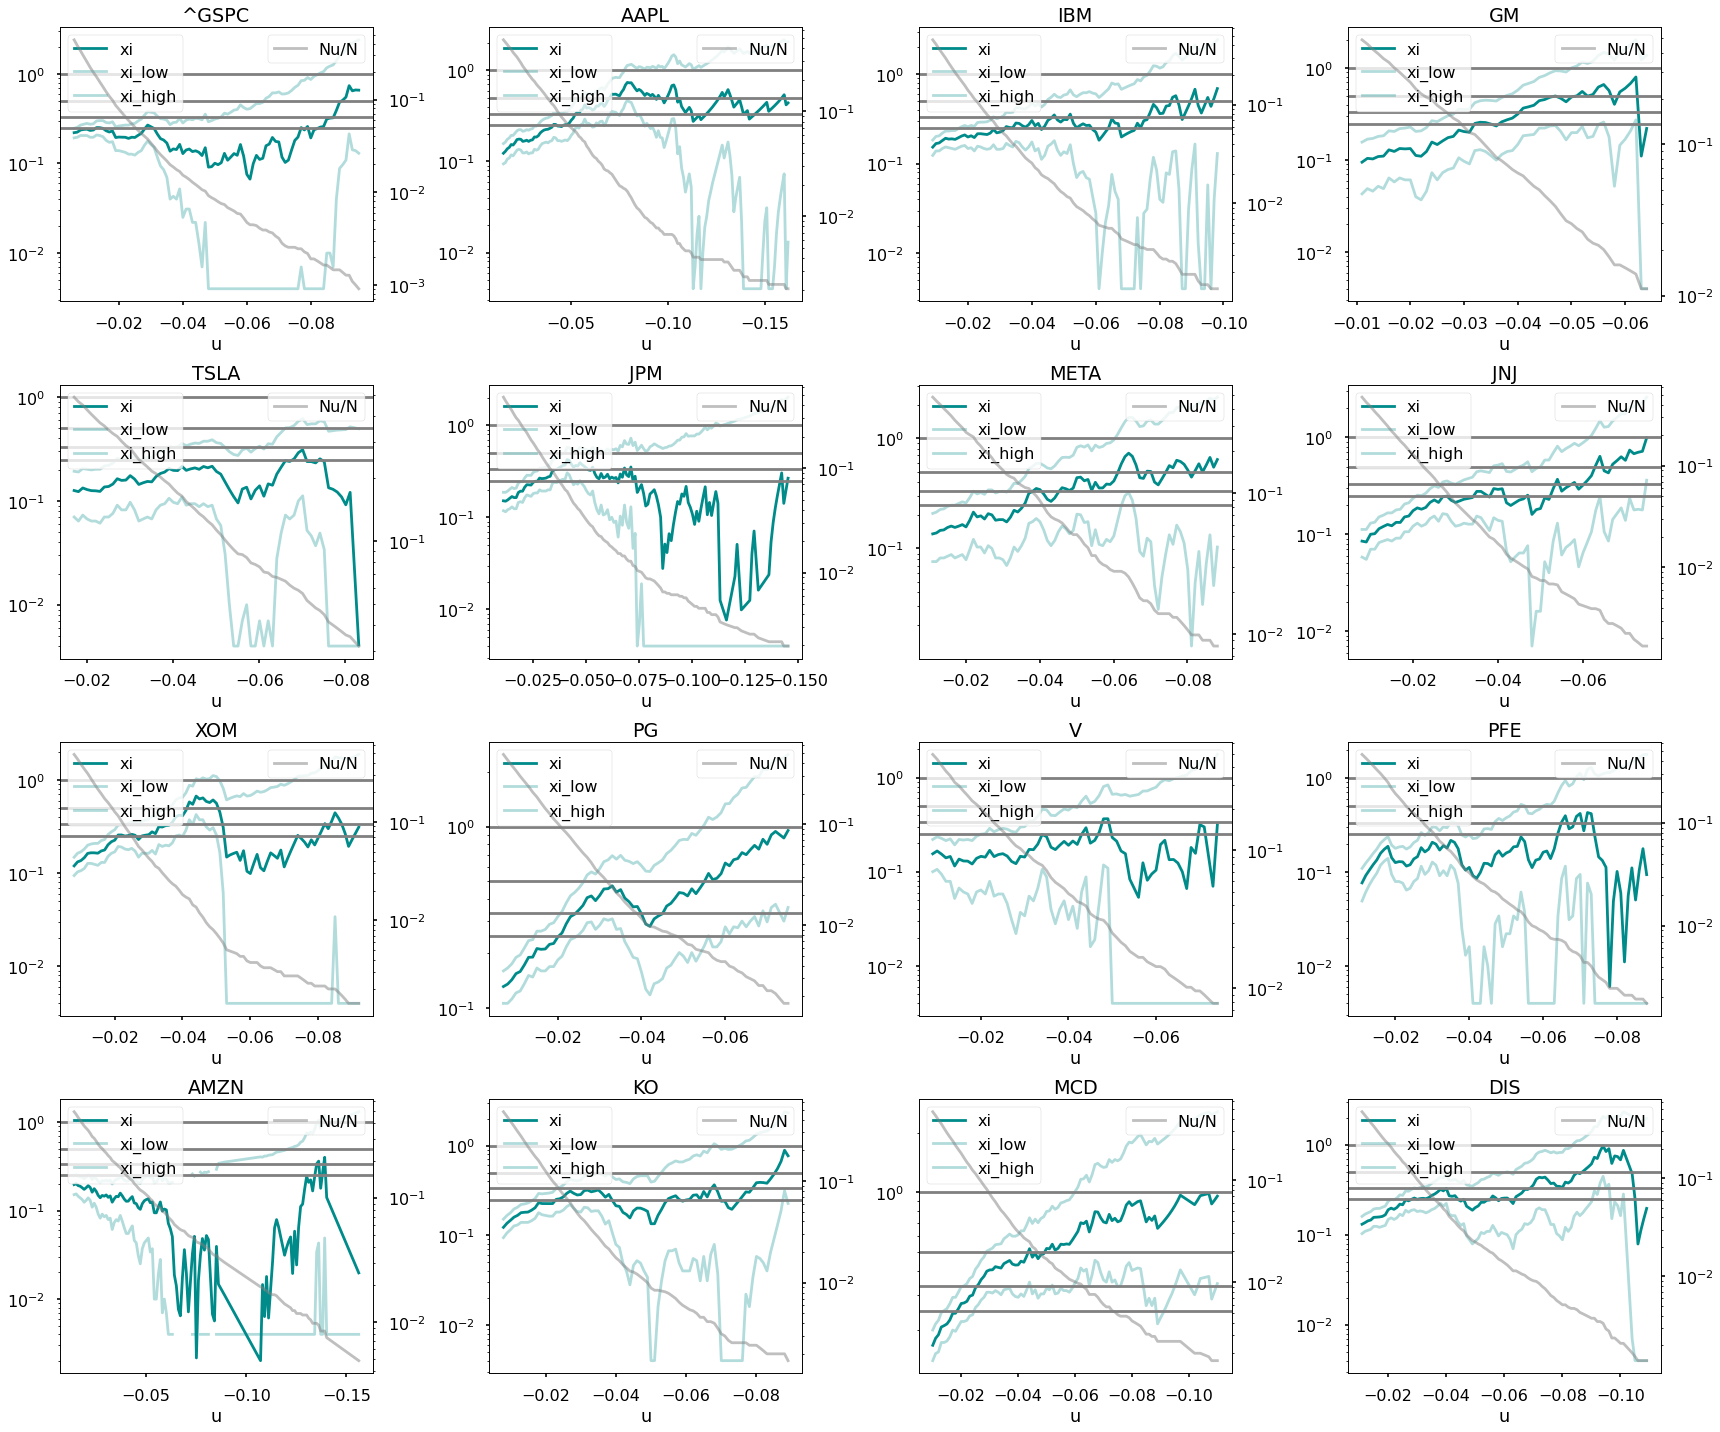

In [25]:
plot_confidence_interval(method='xi', log_y_bool=True, ncols=4)#, list_tickers=['^GSPC', 'AAPL', 'TSLA', ''])

### VaR

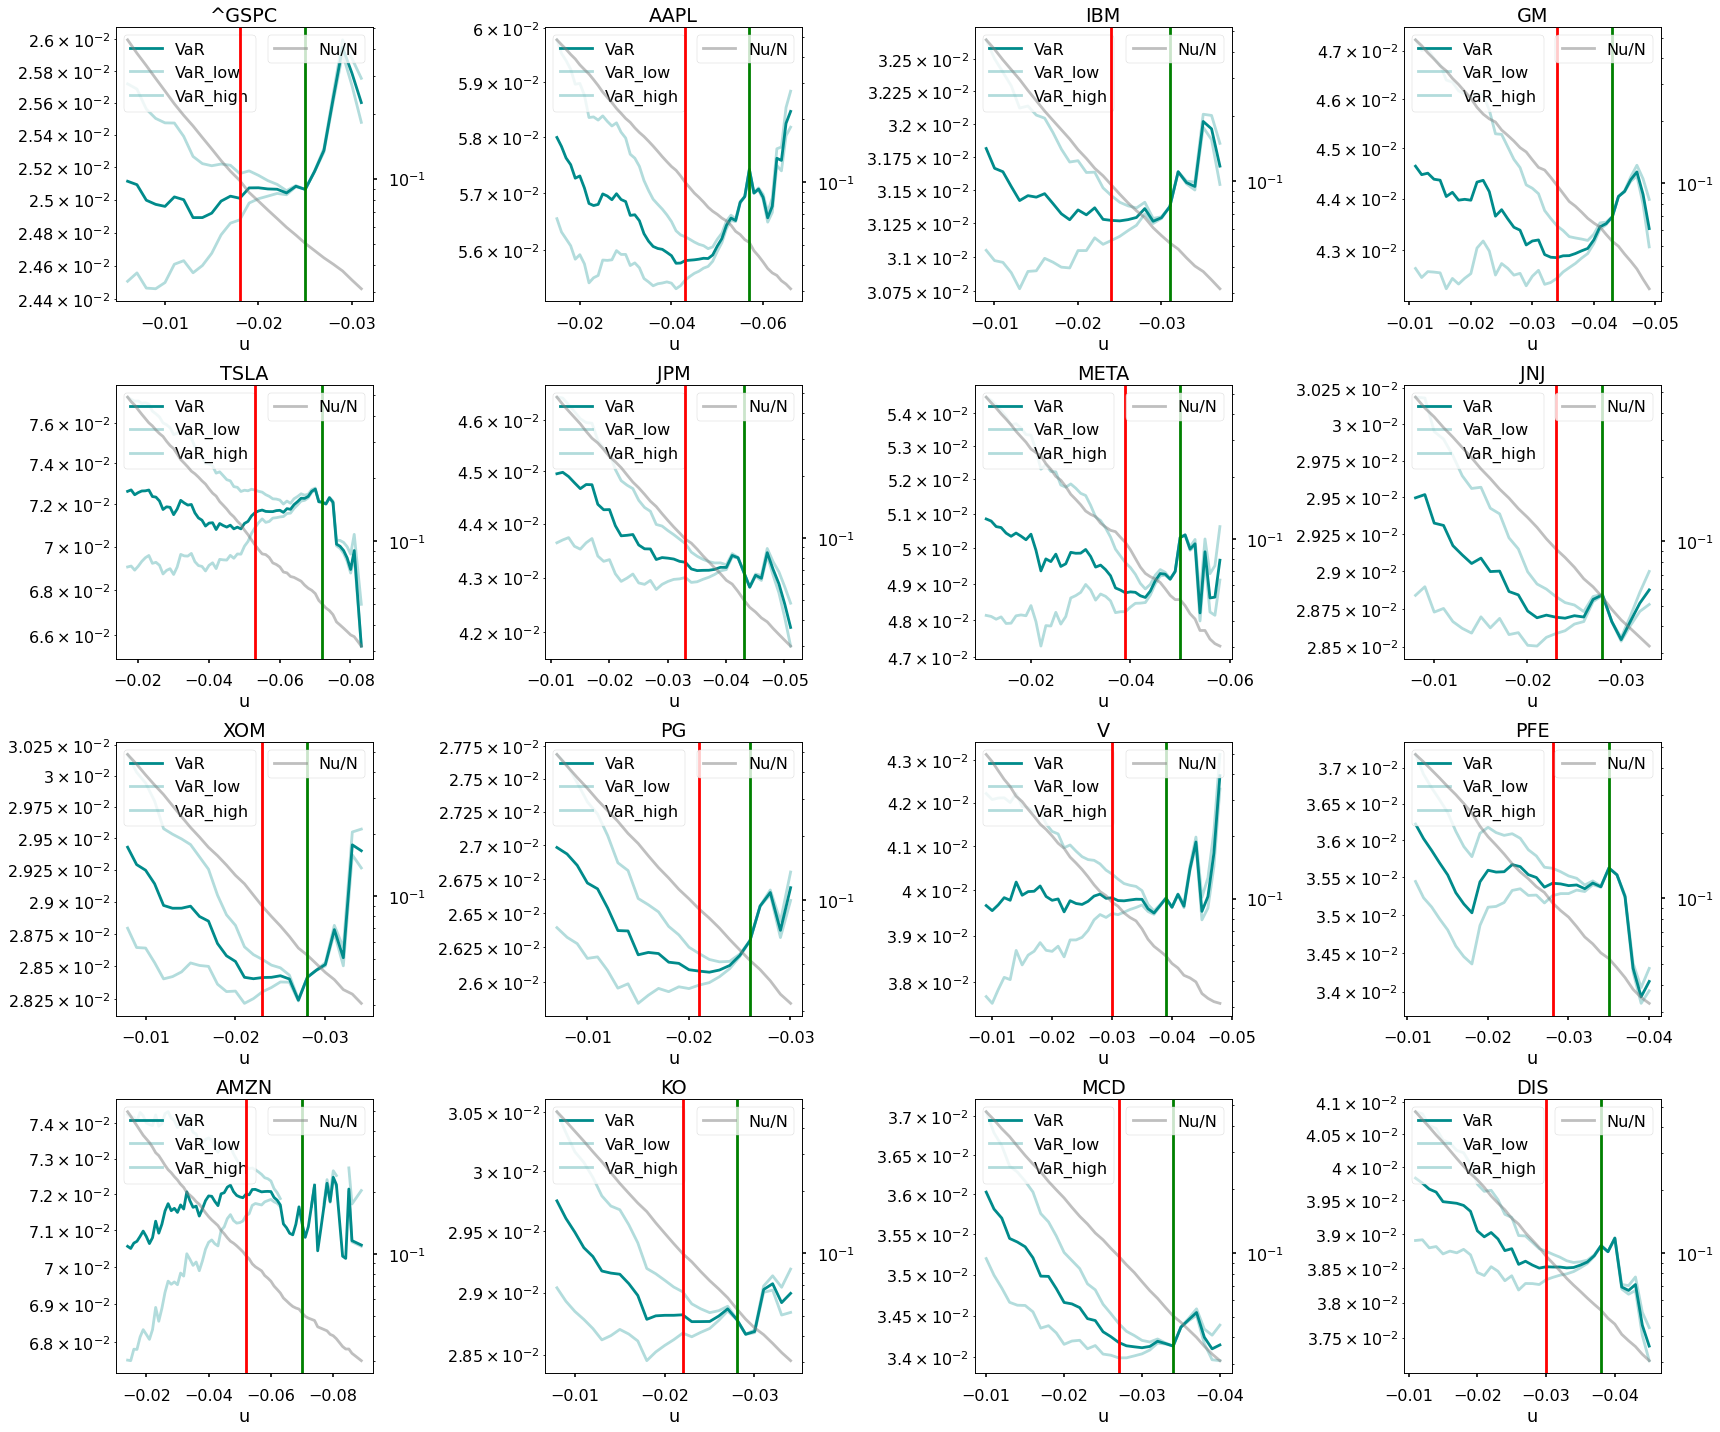

In [26]:
plot_confidence_interval(method='VaR', log_y_bool=True, df_res=df_res[df_res['pct_n'] > 0.03], ncols=4)

In [27]:
## Uncomment this cell for the results on ES, a.k.a. conditional VaR (recommended)
# plot_confidence_interval(method='ES', log_y_bool=True, df_res=df_res[df_res['pct_n'] > 0.03], ncols=4)

# VaR CI width summary

In [28]:
##########################################################
############# Compute VaR at different levels ############
##########################################################

def get_results_at_VaR_level(alpha=0.95,
                             list_experiment=list_experiment):
    '''
    Compute the results for VaR at a given level
    
    Args:
        - alpha: VaR level
    '''
    df_result = pd.concat(list_experiment)
    df_result['pct_n'] = df_result['N_u'] / df_result['N']

    df_result[['VaR_low', 'ES_low']] = df_result.apply(
        lambda se: pd.Series(VaR_ES(u=se['u'], c=se['xi_low'], scale=se['scale'],
                                    N=se['N'], Nu=se['N_u'], alpha=alpha)), axis=1)

    df_result[['VaR', 'ES']] = df_result.apply(
        lambda se: pd.Series(VaR_ES(u=se['u'], c=se['xi'], scale=se['scale'],
                                    N=se['N'], Nu=se['N_u'], alpha=alpha)), axis=1)

    df_result[['VaR_high', 'ES_high']] = df_result.apply(
        lambda se: pd.Series(VaR_ES(u=se['u'], c=se['xi_high'], scale=se['scale'],
                                    N=se['N'], Nu=se['N_u'], alpha=alpha)), axis=1)

    df_result = df_result.set_index(['ticker','u']).sort_index()

    return df_result

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/base.py:937: RuntimeWarning: invalid value encountered in log
  new_values = map_f(values, mapper)


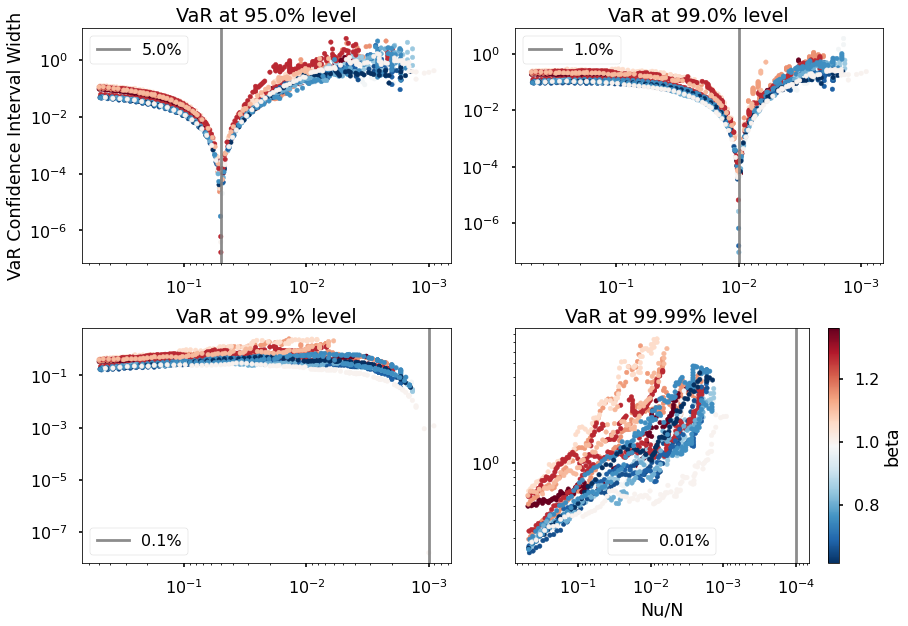

In [29]:
fig, axis = plt.subplots(2,2)
axis = axis.flatten()

list_alpha = [0.95, 0.99, 0.999, 0.9999]

for i, alpha in enumerate(list_alpha):
    _df = get_results_at_VaR_level(alpha=alpha)

    _df = _df.reset_index()
    _df['log_VaR_CI'] = _df.apply(
        lambda se: (se['VaR_high']/se['VaR_low']), axis=1
    ).map(np.log).replace(0, np.nan)
    ax = axis[i]
    
    # Add label at the 4th graph
    if i != 3:
        _df = _df.rename(columns={'beta':''})
        _df.plot.scatter(y='log_VaR_CI', x='pct_n', c=_df[''].to_list(), cmap='RdBu_r', ax=ax)
    else:
        _df.plot.scatter(y='log_VaR_CI', x='pct_n', c='beta', cmap='RdBu_r', ax=ax)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.invert_xaxis()
    
    if i == 0:
        ax.set_ylabel('VaR Confidence Interval Width')
    else:
        ax.set_ylabel('')
    
    if i == 3:
        ax.set_xlabel('Nu/N')
    else:
        ax.set_xlabel('')

    ax.xaxis.get_label().set_visible(True)
    ax.tick_params(axis='x', bottom=True, labelbottom=True)

    ax.axvline(1-alpha, color='grey', alpha=0.9, label=f'{np.round(100*(1-alpha), 2)}%')

    ax.legend()

    ax.set_title(f'VaR at {100*alpha}% level');

fig.tight_layout()

# Linear regression on VaR CI log width

In [30]:
df_var_extreme = get_results_at_VaR_level(alpha=0.9999)
df_var_extreme = df_var_extreme[df_var_extreme['VaR_low'] > 0]

df_var_extreme = df_var_extreme.reset_index()
df_var_extreme['log_VaR_CI'] = df_var_extreme.apply(
    lambda se: (se['VaR_high']/se['VaR_low']), axis=1
).map(np.log)
# ax = df_var_extreme.plot.scatter(y='log_VaR_CI', x='pct_n', c='beta', cmap='RdBu_r')

df_var_extreme = df_var_extreme[['log_VaR_CI', 'pct_n', 'beta']]
df_var_extreme['log_VaR_CI'] = df_var_extreme['log_VaR_CI'].map(np.log)
df_var_extreme['pct_n'] = df_var_extreme['pct_n'].map(np.log)

import statsmodels.api as sm

Y = df_var_extreme['log_VaR_CI']
X = df_var_extreme[['pct_n', 'beta']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.params.rename('linear regression').to_frame()

,linear regression
const,-1.885676
pct_n,-0.349343
beta,0.747777


In [31]:
# print(results.summary().as_latex())
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_VaR_CI   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     1182.
Date:                Fri, 05 Aug 2022   Prob (F-statistic):          1.35e-310
Time:                        21:14:41   Log-Likelihood:                -979.03
No. Observations:                1525   AIC:                             1964.
Df Residuals:                    1522   BIC:                             1980.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8857      0.063    -29.901      0.000      -2.009      -1.762
pct_n         -0.3493      0.007    -48.088      0.000      -0.364      -0.335
beta           0.7478      0.051     14.741      0.000       0.648       0.847
==============================================================================
Omnibus:                       38.448   Durbin-Watson:                   0.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.660
Skew:                           0.316   Prob(JB):                     7.38e-11
Kurtosis:                       3.578   Cond. No.                         29.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

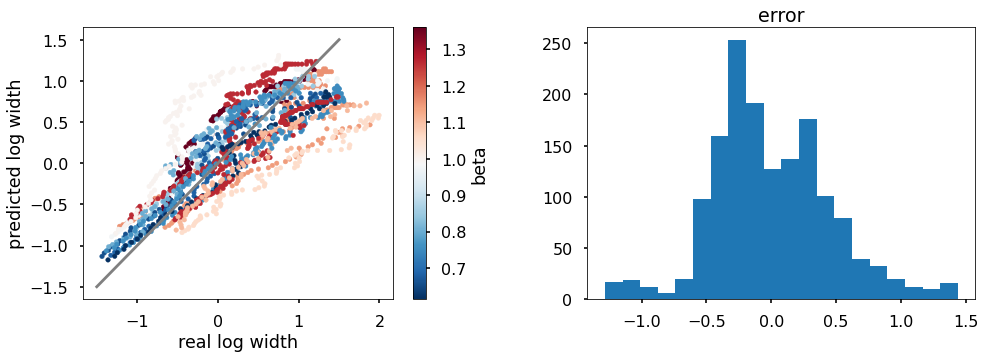

In [32]:
fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2)

df_var_extreme['predicted_width'] = results.predict(X)
df_var_extreme.plot.scatter(x='log_VaR_CI', y='predicted_width', c='beta', cmap='RdBu_r', ax=ax)

ax.set_ylabel('predicted log width')

ax.set_xlabel('real log width')
ax.xaxis.get_label().set_visible(True)
ax.tick_params(axis='x', bottom=True, labelbottom=True)
ax.plot([-1.5, 1.5],[-1.5, 1.5], color='grey')
ax.set_title('');


df_var_extreme['error'] = df_var_extreme['log_VaR_CI'] - df_var_extreme['predicted_width']
df_var_extreme[['error']].hist(bins=20, ax=ax1, grid=False)

fig.set_size_inches(16,5)